# A draft of the segmentation pipeline

## Imports and "Inputs definition"

In [1]:

# IMPORTS

import albumentations as A
import albumentations.pytorch
import cv2
import numpy as np 
import os
import torch
from types import SimpleNamespace

from frameworks.opencv.homography.homography_matrix import BatchHomographyMatrixEstimator
from frameworks.opencv.homography.homography_matrix import RANSAC_MatrixEstimator, Dense_PointFinder
from frameworks.opencv.homography.translate_mask import translate_mask
from frameworks.pytorch.utils.scales_process import torch_batch_scales_process_numpy
from platges_utils.map_model_utils import platja_list_applier, refine_segmentation, normalized_correlation
from platges_utils.model.pyconvsegnet import build_PyConvSegNet_from_params


# CONSTANTS

INPUTS_ROOT = "/mnt/c/Users/Ignasi/Desktop/cosas/test/"
INPUTS = [f.path for f in os.scandir(INPUTS_ROOT) if f.is_file()]

MODEL_NOVA_ICARIA = "./outputs/map_models/nova_icaria.hdf5"
MODEL_BOGATELL = "./outputs/map_models/bogatell.hdf5"

MAP_MODEL_FILENAME_LIST = [MODEL_NOVA_ICARIA, MODEL_BOGATELL]


READ_FLAG = cv2.IMREAD_COLOR

KERNEL = np.ones((50, 50), np.uint8)



## Dataloading mechanisms

In [2]:

def image_loader(inputs, resize_height, resize_width, mean, std):
    
    transforms_list = [
        A.Resize(resize_height, resize_width, interpolation=cv2.INTER_AREA, always_apply=True),
        A.Normalize(mean=mean, std=std),
        A.pytorch.transforms.ToTensorV2()
    ]
    transforms = A.Compose(transforms_list)
    
    for input_ in inputs:

        image = cv2.imread(input_, READ_FLAG) # (#row, #col, #color) (shape = H, W, 3)
        if READ_FLAG == cv2.IMREAD_COLOR : image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        transformed = transforms(image=image)
        transformed_image = transformed["image"]

        yield input_, image, transformed_image


## Preparation for semantic segmentation of the input

In [3]:

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
VALUE_SCALE = 255

params = SimpleNamespace(
    # Parameters updated from data
    mean = [item * VALUE_SCALE for item in MEAN],
    std = [item * VALUE_SCALE for item in STD],
    # Modifiable hyperparams:
    # (add new hyperparameters for any optim, loss, etc)
    num_classes = 3,
    gamma = 2, # if focal_loss
    stride_rate = 2/3,
    scales = [1.0],
    # Data Augmentation parameters:
    resize_height = 512,
    resize_width = 696,
    crop_height = 473,
    crop_width = 473,
    # PyConvSegNet hyperparams:
    funnel_map = True,
    zoom_factor = 8,
    layers = 152,
    num_classes_pretrain = 150,
    backbone_output_stride = 8,
    backbone_net = "pyconvresnet",
    # Pre-trained pathes
    pretrained_back_path = 'model_parameters/original_pyconvsegnet/ade20k_trainval120epochspyconvresnet152_pyconvsegnet.pth',
    adapt_state_dict = False,
    pretrained_path = '/home/ignasi/platges/model_parameters/segments_platgesBCN/pyconvsegnet_platgesBCN_test.pth'
)

build_model_from_params = build_PyConvSegNet_from_params

apply_model = torch_batch_scales_process_numpy


In [4]:

device = torch.device('cpu')

model = build_model_from_params(params)
model = model.to(device)


## Preparation for MapModel utilities usage

In [5]:

# TODO: As authomatic point matching is not working well, define manual point matching for the "ensayo" and later study better this part
point_finder = Dense_PointFinder(1000)
descriptor_finder = None
matrix_finder = None

homography_estimator = BatchHomographyMatrixEstimator(point_finder=point_finder, descriptor_finder=descriptor_finder, matrix_finder=matrix_finder)

mask_translator = translate_mask


## Semantic segmentation, Model matching and Homography segmentation

This step uses the previous segmentation model to generate a mask of the desired "beach plane".\
This mask is used to get a better homography matrix to translate the manual segmentation.\
Then the manual anotation translated through the same space homography matrix is aggregated with the semantic segmentation one.\
Additionally, a similarity score is given to detect the need of a human checking. 

In [6]:

v_semantic_output = []
v_semisupervised_mask = []
v_mask = []
v_score = []

VERBOSE = True
for image_filename, image, transformed_image in image_loader(INPUTS, params.resize_height, params.resize_width, params.mean, params.std):
    if VERBOSE : print(image_filename)
    
    # image # H, W, C
    
    batch_images = transformed_image.numpy().copy() # C, H, W
    batch_images = np.expand_dims(batch_images, axis=0) # B, C, H, W
    
    output = apply_model(model, batch_images, params.num_classes, params.crop_height, params.crop_width, params.mean, params.std, params.scales, base_size=0, stride_rate=params.stride_rate, device=device)
    #if VERBOSE : print(f'{len(output)}, {output[0].shape}')
    output = output[0]
    v_semantic_output.append(output)
    
    points_mask = output.copy()
    points_mask = cv2.resize(points_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    points_mask[points_mask != 2] = 0
    points_mask[points_mask == 2] = 1
    points_mask = cv2.dilate(points_mask, KERNEL, iterations=1)
    
    semisupervised_mask, h, name, image, map_model_filename = platja_list_applier(image_filename, MAP_MODEL_FILENAME_LIST, homography_estimator, mask_translator, 
        image_mask=points_mask,
        distance_funct=None,
        k_nearest=None,
        max_distance=None,
        undefined_class=0,
        nearness_limit=0,
        read_flag=READ_FLAG
    )
    
    if VERBOSE : print(map_model_filename)
    v_semisupervised_mask.append(semisupervised_mask)
    
    output = cv2.resize(output, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    mask, score = refine_segmentation(semisupervised_mask, output, similarity_funct=normalized_correlation, undefined_classes=[0, 3])
    
    if VERBOSE : print(score)
    v_mask.append(mask)
    v_score.append(score)
    
    if VERBOSE : print('---')
    

/mnt/c/Users/Ignasi/Desktop/cosas/test/00_13_58.jpg
./outputs/map_models/nova_icaria.hdf5
1.577831486227228e-08
---
/mnt/c/Users/Ignasi/Desktop/cosas/test/01_13_58.jpg
./outputs/map_models/nova_icaria.hdf5
1.5657918052471243e-08
---
/mnt/c/Users/Ignasi/Desktop/cosas/test/03_13_58.jpg
./outputs/map_models/nova_icaria.hdf5
3.178767006297411e-08
---
/mnt/c/Users/Ignasi/Desktop/cosas/test/04_13_58.jpg
./outputs/map_models/nova_icaria.hdf5
3.094278738660269e-08
---
/mnt/c/Users/Ignasi/Desktop/cosas/test/05_13_58.jpg
./outputs/map_models/bogatell.hdf5
1.6274767679019244e-08
---
/mnt/c/Users/Ignasi/Desktop/cosas/test/07_13_58.jpg
./outputs/map_models/bogatell.hdf5
1.5881409070884207e-08
---
/mnt/c/Users/Ignasi/Desktop/cosas/test/08_13_58.jpg
./outputs/map_models/bogatell.hdf5
2.9332120241268338e-08
---
/mnt/c/Users/Ignasi/Desktop/cosas/test/11_13_58.jpg
./outputs/map_models/bogatell.hdf5
1.58103105237126e-08
---


## Visualization

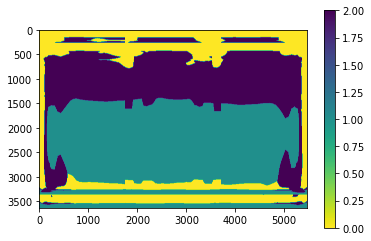

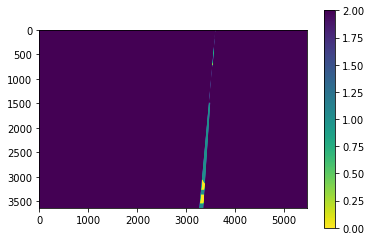

In [ ]:
%matplotlib inline

from matplotlib import pyplot as plt


#for semantic_output, semisupervised_mask, mask, score in zip(v_semantic_output, v_semisupervised_mask, v_mask, v_score):
for semantic_output, semisupervised_mask, mask, score in list(zip(v_semantic_output, v_semisupervised_mask, v_mask, v_score))[3:]:
    semantic_output = cv2.resize(semantic_output, (semisupervised_mask.shape[1], semisupervised_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    plt.imshow(semantic_output, vmin=0, vmax=2)
    plt.colorbar()
    plt.show()
    plt.imshow(semisupervised_mask, vmin=0, vmax=2)
    plt.colorbar()
    plt.show()
    plt.imshow(mask, vmin=0, vmax=2)
    plt.colorbar()
    plt.show()
    print(score)
    break


In [ ]:
# TODO: cv2.findContours : https://stackoverflow.com/a/64649730